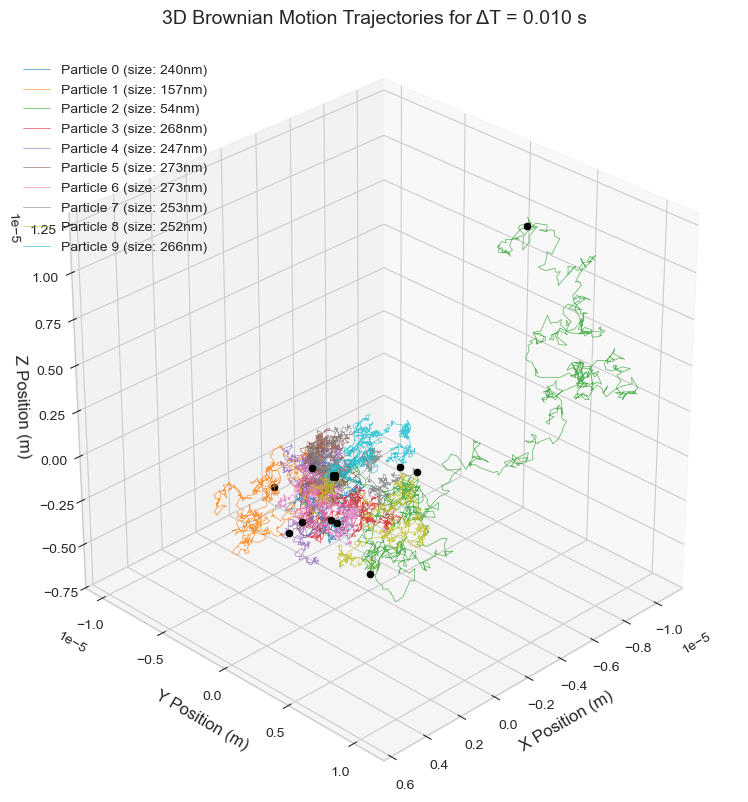

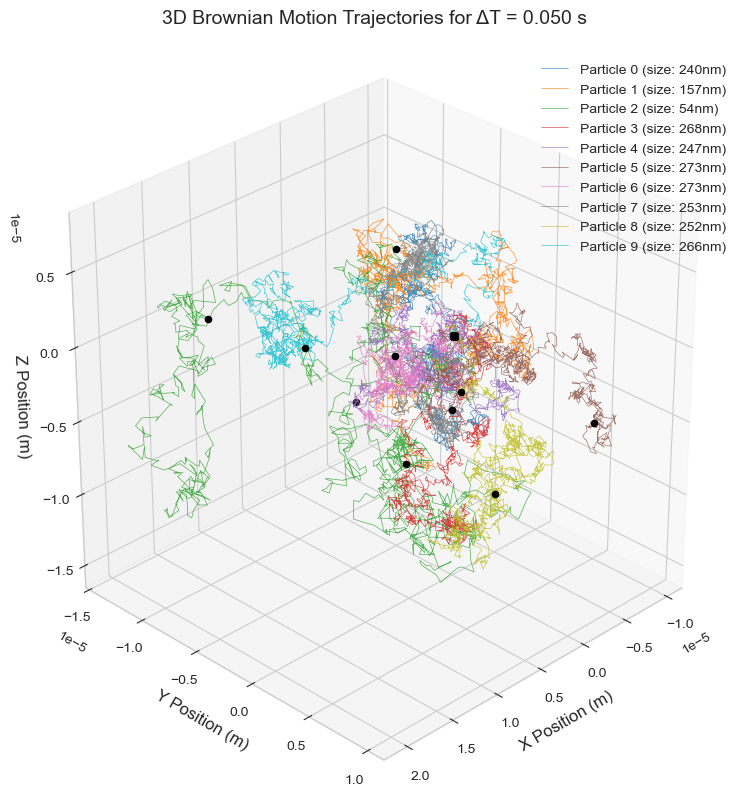

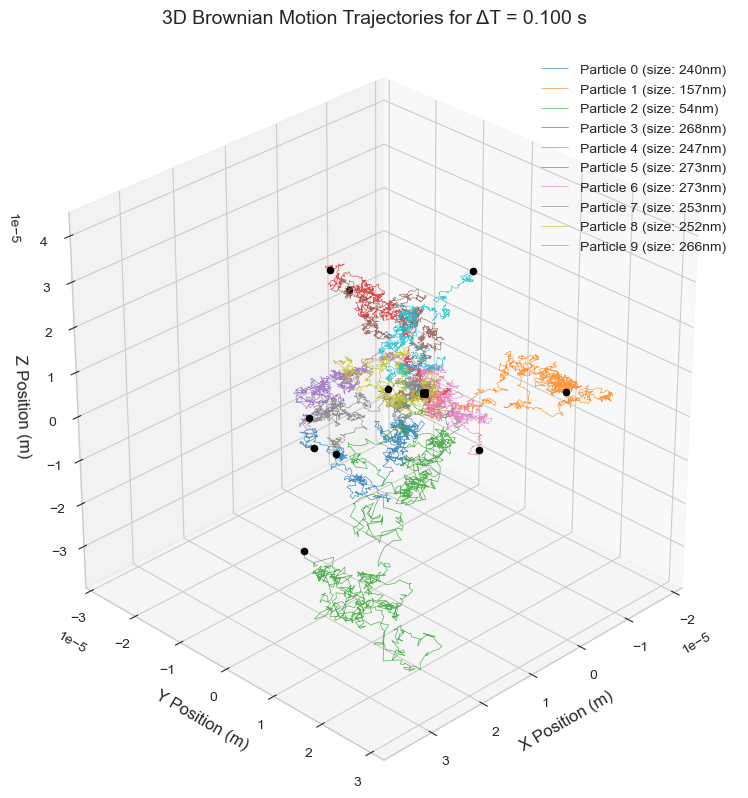

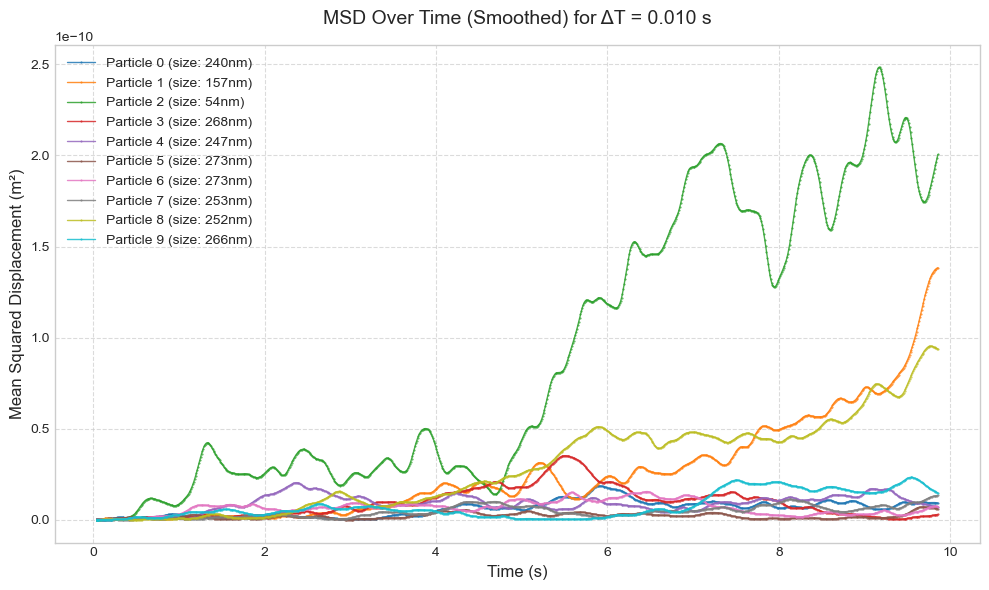

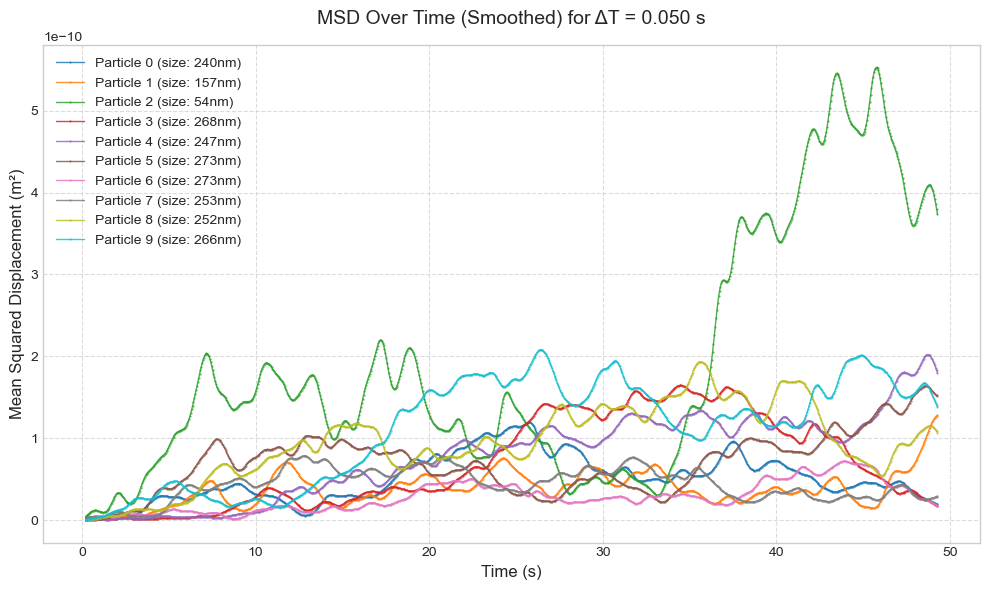

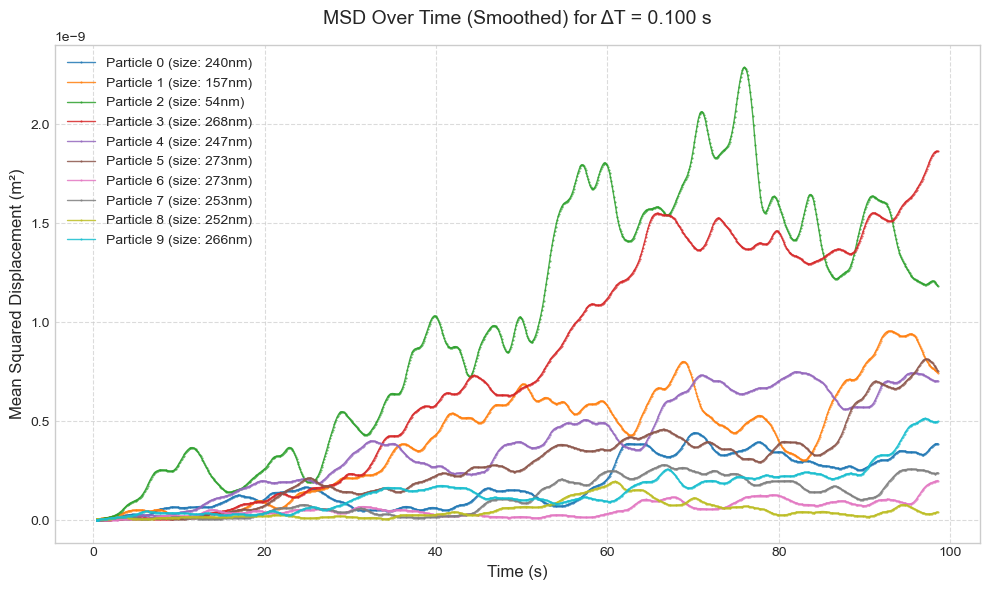

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Use a clean style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# Folder where the CSV files are located
folder_path = r"D:/Thesis_Workspace/Main_Cplusplus/brownian_v1.6"  # Adjust as needed

def format_particle_size(size):
    """
    Convert a particle size from meters to nanometers and return a string in layman's terms.
    For example, if the particle size is 2.8e-8 m, it returns "28nm".
    If the conversion fails, returns "Unknown".
    """
    try:
        size_float = float(size)
        size_nm = size_float * 1e9  # Convert meters to nanometers
        return f"{size_nm:.0f}nm"
    except (ValueError, TypeError):
        return "Unknown"

#############################################
# 1. 3D Trajectory Plots per ΔT             #
#############################################

# Find files that start with "traj_dt" and end with ".csv"
traj_pattern = os.path.join(folder_path, "traj_dt*.csv")
traj_csv_files = glob.glob(traj_pattern)

if not traj_csv_files:
    print("No trajectory CSV files found in:", folder_path)
else:
    # Group files by ΔT value extracted from filename (e.g. "traj_dt0.01.csv")
    dt_groups = {}
    for csv_file in traj_csv_files:
        basename = os.path.basename(csv_file)
        dt_val = basename.replace("traj_dt", "").replace(".csv", "")
        dt_groups.setdefault(dt_val, []).append(csv_file)

    for dt_val in sorted(dt_groups.keys(), key=lambda x: float(x)):
        # Combine all trajectory data for this ΔT value
        df_all = pd.concat([pd.read_csv(f) for f in dt_groups[dt_val]], ignore_index=True)
        
        # Group data by particle; each group contains all trajectory points for that particle.
        grouped = df_all.groupby("particle")
        particles = sorted(df_all["particle"].unique())
        cmap = plt.get_cmap("tab10", len(particles))
        particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        
        # Plot each particle's trajectory.
        for p, group in grouped:
            if "time" in group.columns:
                group = group.sort_values("time")
            raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
            particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
            label = f"Particle {p} (size: {particle_size})"
            
            ax.plot(group["x"], group["y"], group["z"],
                    color=particle_colors[p], alpha=0.8, linewidth=0.5,
                    label=label)
            # Mark the starting point (yellow square)
            ax.scatter(group["x"].iloc[0],
                       group["y"].iloc[0],
                       group["z"].iloc[0],
                       color="black", marker="s", s=20, zorder=5)
            # Mark the ending point (black circle)
            ax.scatter(group["x"].iloc[-1],
                       group["y"].iloc[-1],
                       group["z"].iloc[-1],
                       color="black", marker="o", s=20, zorder=5)
        
        ax.set_xlabel("X Position (m)", fontsize=12)
        ax.set_ylabel("Y Position (m)", fontsize=12)
        ax.set_zlabel("Z Position (m)", fontsize=12)
        ax.set_title(f"3D Brownian Motion Trajectories for ΔT = {float(dt_val):.3f} s", 
                     fontsize=14, pad=20)
        ax.view_init(elev=30, azim=45)
        try:
            ax.set_box_aspect((1, 1, 1))
        except Exception:
            pass
        ax.legend(fontsize=10)
        fig.tight_layout()
        # Optionally, save the figure:
        # fig.savefig(f"trajectory_dt_{dt_val}.png", dpi=300)

#############################################
# 2. MSD Line Charts per ΔT                 #
#############################################

# Find files that start with "msd_dt" and end with ".csv"
msd_pattern = os.path.join(folder_path, "msd_dt*.csv")
msd_files = glob.glob(msd_pattern)

def smooth_data(series, window=10, iterations=3):
    """Smooths a data series using a rolling mean."""
    for _ in range(iterations):
        series = series.rolling(window=window).mean().bfill()
    return series

if not msd_files:
    print("No MSD CSV files found in:", folder_path)
else:
    # Group MSD files by ΔT value (e.g. "msd_dt0.01.csv")
    msd_dt_groups = {}
    for msd_file in msd_files:
        basename = os.path.basename(msd_file)
        dt_val = basename.replace("msd_dt", "").replace(".csv", "")
        msd_dt_groups.setdefault(dt_val, []).append(msd_file)
    
    for dt_val in sorted(msd_dt_groups.keys(), key=lambda x: float(x)):
        # Combine all MSD data for this ΔT value
        df_msd_all = pd.concat([pd.read_csv(f) for f in msd_dt_groups[dt_val]], ignore_index=True)
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if "particle" in df_msd_all.columns:
            # Plot each particle separately.
            particles = sorted(df_msd_all["particle"].unique())
            cmap = plt.get_cmap("tab10", len(particles))
            particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
            for p, group in df_msd_all.groupby("particle"):
                group = group.sort_values("time").copy()
                group["smoothed_time"] = smooth_data(group["time"])
                group["smoothed_msd"] = smooth_data(group["msd"])
                raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
                particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
                ax.plot(group["smoothed_time"], group["smoothed_msd"],
                        color=particle_colors[p],
                        label=f"Particle {p} (size: {particle_size})",
                        linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        else:
            # Otherwise, plot a single curve for the entire ΔT group.
            df_msd_all["smoothed_time"] = smooth_data(df_msd_all["time"])
            df_msd_all["smoothed_msd"] = smooth_data(df_msd_all["msd"])
            ax.plot(df_msd_all["smoothed_time"], df_msd_all["smoothed_msd"],
                    label=f"MSD dt={dt_val}", linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        
        ax.set_xlabel("Time (s)", fontsize=12)
        ax.set_ylabel("Mean Squared Displacement (m²)", fontsize=12)
        ax.set_title(f"MSD Over Time (Smoothed) for ΔT = {float(dt_val):.3f} s", 
                     fontsize=14, pad=15)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=10)
        fig.tight_layout()
        # Optionally, save the figure:
        # fig.savefig(f"msd_dt_{dt_val}.png", dpi=300)

# Finally, display all figures.
plt.show()
